# HOMEWORK2 : IS-ACADEMIA

## Exercice 1 

In [11]:
%matplotlib inline
import requests
import bs4
import numpy as np

1. First of all, we extract the dataset from is-academia and we parse it using beautifulSoup

In [12]:
#function that extracts the data from is-academia
#takes as input the level of studies('bachelor 1,2,3 ...), the section (in this homework, we extract the data from 
#Section Informatique), the period (a vector for example : [2007,2011])
#Example : extract_data('Bachelor semestre 1','Informatique','[2007,2017]','Semestre d'automne') will return
#all the data of all the bachelor semestre 1 of the Informatique section from 2007 to 2017 into a dictionary format
#{2007:'data for bachelor 1 in 2007',2008:'data for bachelor 1 in 2008',...}
def extract_data(level,section,period,type_semestre):
    dict={}
    dict_data={}
    request = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter',{'ww_i_reportmodel':'133685247','ww_i_reportModelXsl':'133685271'})
    html_doc=request.content
    soup = bs4.BeautifulSoup(html_doc, 'html.parser')
    #find the parameter relative to the section,level(ie: bachelor 1,2,3 ...) and to the type of semester
    #(ie: automne or hiver)
    for option in soup.findAll('option'):
        if option.text==section:
            value_section=option.get('value') 
        if option.text==level:
            value_level=option.get('value')
        if option.text==type_semestre:
            value_type=option.get('value')
    x=period[0]
    while x<= period[1]-1 and x>=period[0]:
        for option in soup.findAll('option'):
            year=str(x)+'-'+str(x+1)
            if option.text==year:
               dict[year]=option.get('value')
        data = {'ww_i_reportmodel':'133685247','ww_i_reportModelXsl':'133685271','ww_x_UNITE_ACAD':str(value_section),'ww_x_PERIODE_ACAD':str(dict[year]),'ww_x_PERIODE_PEDAGO':str(value_level),'ww_x_HIVERETE':str(value_type),'ww_x_GPS':-1}
        r=requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html',params=data).text
        dict_data[year]=requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html',params=data).text
        x=x+1
    return dict_data

- Create functions that given a certain html page, returns the data (gender, name, sciper)

In [13]:
def names(page):
    soup = bs4.BeautifulSoup(page, 'html.parser')
    table=[tr.findAll('td') for tr in soup.findAll('tr')]
    table=table[3:]
    names=[]
    for i in range(len(table)):
        names=names+[table[i][1].get_text().replace('\xa0',' ')]
    return names

In [14]:
def genders(page):
    soup = bs4.BeautifulSoup(page, 'html.parser')
    table=[tr.findAll('td') for tr in soup.findAll('tr')]
    table=table[3:]
    gender=[]
    for i in range(len(table)):
        gender=gender+[table[i][0].get_text().replace('\xa0',' ')]
    return gender

In [15]:
def sciper(page):
    soup = bs4.BeautifulSoup(page, 'html.parser')
    table=[tr.findAll('td') for tr in soup.findAll('tr')]
    table=table[3:]
    scipers={}
    for i in range(len(table)):
        scipers[table[i][10].get_text().replace('\xa0',' ')]=table[i][0].get_text().replace('\xa0',' ')
    return scipers

In [16]:
B1=extract_data('Bachelor semestre 1','Informatique',[2007,2017],"Semestre d'automne")
B6=extract_data('Bachelor semestre 6','Informatique',[2007,2017],"Semestre de printemps")

- firstB1 and lastB6 are two functions that take a sciper number and returns respectively the first BA1 semester and the last BA6 semester in which the student appears


In [17]:
def firstB1(sci):
    year=2007
    b=True
    while year<2017 and b:
        yearstr=str(year)+'-'+str(year+1)
        if str(sci) in sciper(B1[yearstr]).keys():
            b=False
        else:
            year=year+1
    return year

In [18]:
def lastB6(sci):
    year=2007
    lastyear=0
    while year<2017:
        yearstr=str(year)+'-'+str(year+1)
        if str(sci) in sciper(B6[yearstr]).keys():
            lastyear=year
        year=year+1
    return lastyear

In [19]:
import pandas
sciB1={}
#sciB1 is a dictionary with all the BA1 scipers as keys and Gender's as values  between 2007 and 2017
for year in range(2007,2017):
    sciB1.update(sciper(B1[str(year)+'-'+str(year+1)]))

In [20]:
sciB6={}
#sciB6 is a dictionary with all the BA6 scipers as keys and Gender's as values between 2007 and 2017
for year in range(2007,2017):
    sciB6.update(sciper(B6[str(year)+'-'+str(year+1)]))

- sciB6 is a dictionary with all sciper students who appeared both in BA1 and BA6.
- The idea is to store all the students that did succeed to go from BA1 to BA6

In [21]:
interB1B6={}
for key in set(sciB1).intersection(set(sciB6)):
    interB1B6[key]=sciB1[key]

-diffB1B6 is a dictionary with the number of years that a student took from BA1 to BA6

In [22]:
diffB1B6={}
for scip in interB1B6.keys():
    diffB1B6[scip]=lastB6(scip)-firstB1(scip)

In [23]:
tab1=pandas.DataFrame.from_dict(interB1B6, orient='index', dtype=None)
tab1.columns = ['Gender']
tab1.head()

,Gender
226703,Monsieur
205612,Madame
226652,Monsieur
218357,Monsieur
194171,Monsieur


In [24]:
tab2=pandas.DataFrame.from_dict(diffB1B6, orient='index', dtype=None)
tab2.columns = ['Num Years']
tab2['Num Years']=12*tab2['Num Years']+6
tab2.head()

,Num Years
226703,30
205612,30
226652,42
218357,30
194171,30


In [25]:
tab=pandas.concat([tab1,tab2],axis=1)
tab.head()

,Gender,Num Years
147008,Monsieur,30
169569,Monsieur,30
169731,Monsieur,42
169795,Monsieur,42
171195,Monsieur,30


- Here, we can see the average and the standard deviation of number of years it took each student to go from the first to the sixth semester by gender.
- We notice that the results are scarcely different.

In [26]:
tab.groupby('Gender')['Num Years'].mean()

Gender
Madame      33.724138
Monsieur    35.771739
Name: Num Years, dtype: float64

In [27]:
tab.groupby('Gender')['Num Years'].std()

Gender
Madame      6.496684
Monsieur    8.943788
Name: Num Years, dtype: float64

- To answer the question of the exercise, we notice that the number of women from 2007 to 2016 is very low compared to the number of men: 
- Also, the mean is not robust to outliers which means that a simple outlier could influence the estimator. That's why the results are not significant.


In [33]:
tab['Gender'].value_counts()

Monsieur    368
Madame       29
Name: Gender, dtype: int64

# Exercice 2

### Useful dictionaries

We define dictionaries with pages of different levels of Master between 2007 and 2017.

We define 3 dictionaries :
- occurM : SCIPER -> occurence in Master pages
- gendersM : SCIPER -> gender
- firstM1 : SCIPER -> first Master 1

In [34]:
M1=extract_data('Master semestre 1','Informatique',[2007,2017],"Semestre d'automne")
M2=extract_data('Master semestre 2','Informatique',[2007,2017],"Semestre de printemps")
M3=extract_data('Master semestre 3','Informatique',[2007,2017],"Semestre d'automne")

In [35]:
occurM={}
gendersM={}
firstM1={}
for year in range(2007,2017):
    soupM1 = bs4.BeautifulSoup(M1[str(year)+'-'+str(year+1)], 'html.parser')
    tableM1=[tr.findAll('td') for tr in soupM1.findAll('tr')]
    tableM1=tableM1[3:]
    soupM2 = bs4.BeautifulSoup(M2[str(year)+'-'+str(year+1)], 'html.parser')
    tableM2=[tr.findAll('td') for tr in soupM2.findAll('tr')]
    tableM2=tableM2[3:]
    soupM3 = bs4.BeautifulSoup(M3[str(year)+'-'+str(year+1)], 'html.parser')
    tableM3=[tr.findAll('td') for tr in soupM3.findAll('tr')]
    tableM3=tableM3[3:]
    #we don't consider the year 2017 because we don't know if its Master student will finish
    if year!=2016:
         #Master 1
        for i in range(len(tableM1)):
            if tableM1[i][10].get_text().replace('\xa0',' ') in occurM.keys():
            #Incrementation of occurences for the current student
                occurM[tableM1[i][10].get_text().replace('\xa0',' ')]=occurM[tableM1[i][10].get_text().replace('\xa0',' ')]+1
            else:
            #Initialisation of occurences for the current student
                occurM[tableM1[i][10].get_text().replace('\xa0',' ')]=1
            if not tableM1[i][10].get_text().replace('\xa0',' ') in firstM1.keys():
            #First Master 1 of the current student
                firstM1[tableM1[i][10].get_text().replace('\xa0',' ')]=year
            #Gender of the current student
            gendersM[tableM1[i][10].get_text().replace('\xa0',' ')]=tableM1[i][0].get_text().replace('\xa0',' ')
        #Master 2
        for i in range(len(tableM2)):
            if tableM2[i][10].get_text().replace('\xa0',' ') in occurM.keys():
                occurM[tableM2[i][10].get_text().replace('\xa0',' ')]=occurM[tableM2[i][10].get_text().replace('\xa0',' ')]+1
        #Master 3 (we don't consider the years 2007 and 2008 because we don't know when the student began his master)
        if year!=2007 and year!=2008:
            for i in range(len(tableM3)):
                if tableM3[i][10].get_text().replace('\xa0',' ') in occurM.keys():
                    occurM[tableM3[i][10].get_text().replace('\xa0',' ')]=occurM[tableM3[i][10].get_text().replace('\xa0',' ')]+1
    #deleting of the students that are in 2016-2017 lists 
    else:
        for i in range(len(tableM1)):
            if tableM1[i][10].get_text().replace('\xa0',' ') in occurM: del occurM[tableM1[i][10].get_text().replace('\xa0',' ')]
            if tableM1[i][10].get_text().replace('\xa0',' ') in gendersM: del gendersM[tableM1[i][10].get_text().replace('\xa0',' ')]
            if tableM1[i][10].get_text().replace('\xa0',' ') in firstM1: del firstM1[tableM1[i][10].get_text().replace('\xa0',' ')]
        for i in range(len(tableM2)):
            if tableM2[i][10].get_text().replace('\xa0',' ') in occurM: del occurM[tableM2[i][10].get_text().replace('\xa0',' ')]
            if tableM2[i][10].get_text().replace('\xa0',' ') in gendersM: del gendersM[tableM2[i][10].get_text().replace('\xa0',' ')]
            if tableM2[i][10].get_text().replace('\xa0',' ') in firstM1: del firstM1[tableM2[i][10].get_text().replace('\xa0',' ')]
        for i in range(len(tableM3)):
            if tableM3[i][10].get_text().replace('\xa0',' ') in occurM: del occurM[tableM3[i][10].get_text().replace('\xa0',' ')]
            if tableM3[i][10].get_text().replace('\xa0',' ') in gendersM: del gendersM[tableM3[i][10].get_text().replace('\xa0',' ')]
            if tableM3[i][10].get_text().replace('\xa0',' ') in firstM1: del firstM1[tableM3[i][10].get_text().replace('\xa0',' ')]


### DataFrames creation :

Occurences DataFrame : Number of semesters it took each master student to complete his master.

In [37]:
frameOccur=pandas.DataFrame.from_dict(occurM,orient='index')
frameOccur.columns=['Nbre mois']
frameOccur.head()

,Nbre mois
180160,2
205612,5
233587,3
201600,6
198216,3


Genders DataFrame :

In [38]:
frameGenders=pandas.DataFrame.from_dict(gendersM,orient='index')
frameGenders.columns=['Gender']
frameGenders.head()

,Gender
180160,Monsieur
205612,Madame
233587,Monsieur
201600,Monsieur
198216,Monsieur


- First Master 1 DataFrame : Here we store the first date in which the student appears in semester 1.

In [40]:
frameFirstM1=pandas.DataFrame.from_dict(firstM1,orient='index')
frameFirstM1.columns=['First M1']
frameFirstM1.head()

,First M1
180160,2007
205612,2013
233587,2013
201600,2013
198216,2013


Conversion of occurences into months :

In [41]:
frameOccur['Nbre mois']=6*frameOccur['Nbre mois']+6

In [44]:
frameOccur.head()

,Nbre mois
180160,18
205612,36
233587,24
201600,42
198216,24


- Specialisation dataframe

In [43]:
def specilisation(page):
    soup = bs4.BeautifulSoup(page, 'html.parser')
    table=[tr.findAll('td') for tr in soup.findAll('tr')]
    table=table[3:]
    spec={}
    for i in range(len(table)):
        if  table[i][4].get_text().replace('\xa0',' '):
            spec[table[i][10].get_text().replace('\xa0',' ')]=table[i][4].get_text().replace('\xa0',' ')
        else:
            spec[table[i][10].get_text().replace('\xa0',' ')]='Without Specialisation'
    return spec

In [46]:
specM1={}
specM2={}
specM3={}
spec_master={}
for year in range(2007,2017):
    specM1.update(specilisation(M1[str(year)+'-'+str(year+1)]))
    specM2.update(specilisation(M2[str(year)+'-'+str(year+1)]))
    specM3.update(specilisation(M2[str(year)+'-'+str(year+1)]))

In [48]:
spec_master.update(specM2)
spec_master.update(specM1)
spec_master.update(specM3)

- Here we create a dataframe from a dictionary. The idea is to consider only students who have been considered for our framework (ie that occur in occurM) and to remove all the others from the spec_master dictionary which stored all the master scipers as keys and their respective specialisation as values.

In [49]:
specialisation_MA={}
for x in occurM.keys():
    specialisation_MA[x]=spec_master[x]

In [50]:
frameSpec=pandas.DataFrame.from_dict(specialisation_MA,orient='index')
frameSpec.columns=['Specialisation']
frameSpec.head()

,Specialisation
180160,Internet computing
205612,Foundations of Software
175703,Internet computing
181017,Without Specialisation
237304,Without Specialisation


DataFrames concatenation : 

In [51]:
frameMa=pandas.concat([frameSpec,frameOccur,frameGenders,frameFirstM1],axis=1)
frameMa=frameMa[frameMa['First M1']!=2015]

In [226]:
frameMa.groupby('Specialisation')['Nbre mois'].mean()

Specialisation
Biocomputing                      30.000000
Computer Engineering - SP         26.727273
Foundations of Software           28.500000
Information Security - SP         30.000000
Internet computing                27.937500
Service science                   27.000000
Signals, Images and Interfaces    30.000000
Software Systems                  26.666667
Without Specialisation            23.336170
Name: Nbre mois, dtype: float64

- Average number of months for each specialisation

In [227]:
frameMa.groupby('Specialisation')['Nbre mois'].mean()

Specialisation
Biocomputing                      30.000000
Computer Engineering - SP         26.727273
Foundations of Software           28.500000
Information Security - SP         30.000000
Internet computing                27.937500
Service science                   27.000000
Signals, Images and Interfaces    30.000000
Software Systems                  26.666667
Without Specialisation            23.336170
Name: Nbre mois, dtype: float64

In [52]:
std=frameMa.groupby('Specialisation')['Nbre mois'].mean().std()

- We notice that all the means are inside the confidence interval, which means that no specialisation stands out.

In [53]:
frameMa.groupby('Specialisation')['Nbre mois'].mean().mean()-2*std

23.435795931960129

In [54]:
frameMa.groupby('Specialisation')['Nbre mois'].mean().mean()+2*std

32.157006202863279

In [55]:
frameMa.groupby('Specialisation')['Nbre mois'].std()

Specialisation
Biocomputing                      0.000000
Computer Engineering - SP         3.133398
Foundations of Software           6.607539
Information Security - SP         0.000000
Internet computing                6.161517
Service science                   4.242641
Signals, Images and Interfaces    6.572671
Software Systems                  3.162278
Without Specialisation            5.904876
Name: Nbre mois, dtype: float64

In [56]:
frameMa['Nbre mois'].mean()

24.53846153846154

In [57]:
frameMa['Nbre mois'].std()

6.2729612795881149

In [58]:
frameMa['Nbre mois'].mean()+2*frameMa['Nbre mois'].std()

37.084384097637766

In [59]:
frameMa['Nbre mois'].mean()-2*frameMa['Nbre mois'].std()

11.99253897928531

# Exercice 3

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
timeEvol = frameMa.groupby(['First M1','Gender'])['Nbre mois'].mean()

In [62]:
timeEvol=timeEvol.to_frame()

In [63]:
timeEvol.reset_index(inplace=True)

- Dataframes : mean number of months for each gender per year.

In [67]:
timeEvol.pivot(index='First M1',columns='Gender',values='Nbre mois')

Gender,Madame,Monsieur
First M1,,
2007,19.200000,19.672131
2008,24.000000,22.352941
2009,22.500000,24.954545
2010,27.230769,24.600000
2011,25.058824,25.769231
2012,25.846154,26.333333
2013,25.200000,25.500000
2014,25.333333,25.521127


In [65]:
timeEvol=timeEvol.reindex()

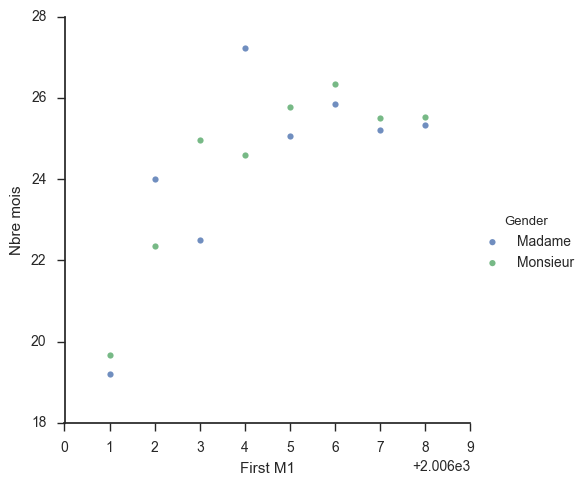

In [66]:
sns.set_context('notebook')
sns.set_style('ticks')
sns.lmplot('First M1','Nbre mois',data=timeEvol,fit_reg=False,hue='Gender')

- Here, you can find the scatter plot of the number of months for males and females : we notice that there is a general trend for both males and females. In fact, students take more time to finish their master from 2007 to 2017.
- Also, we notice that males and females tend to get closer in the number of month to complete the master.
- However, the number of females remains relatively too small to make any conclusion.